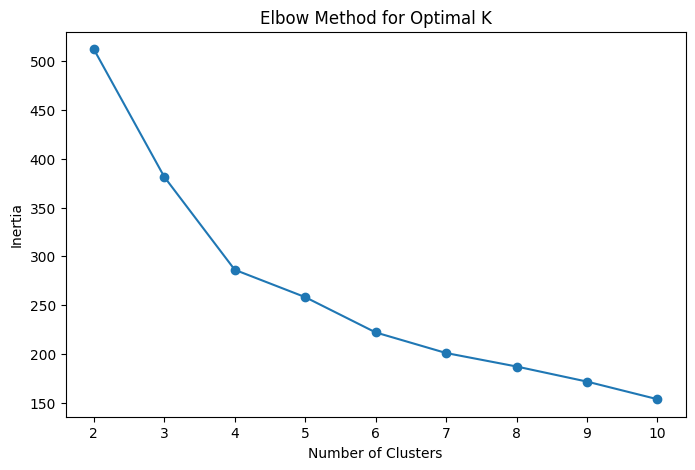

Davies-Bouldin Index: 0.96


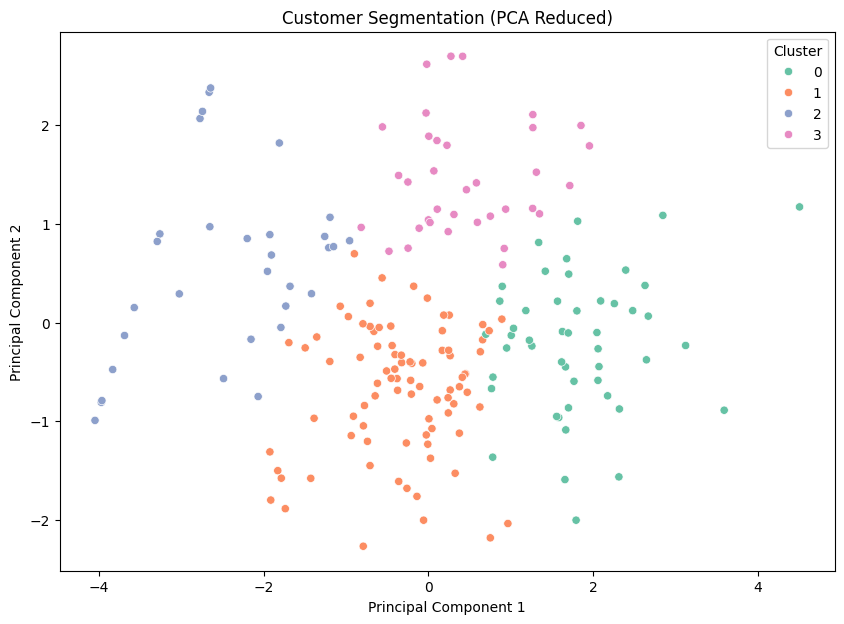

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets
merged = pd.merge(transactions, customers, on="CustomerID")

# Feature Engineering
# Aggregate transaction data for each customer
customer_data = merged.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    NumTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean"),
    DaysSinceSignup=("TransactionDate", lambda x: (pd.to_datetime(x.max()) - pd.to_datetime(x.min())).days)
).reset_index()

# Replace NaN values
customer_data.fillna(0, inplace=True)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop(columns="CustomerID"))

# Determine the optimal number of clusters using the elbow method
inertia = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Choose the optimal number of clusters (e.g., 4 based on elbow curve)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to the original data
customer_data["Cluster"] = kmeans.labels_

# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=customer_data["Cluster"],
    palette="Set2",
    legend="full"
)
plt.title("Customer Segmentation (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
customer_data.to_csv("FirstName_LastName_Clustering.csv", index=False)

# Save metrics to a report
with open("FirstName_LastName_Clustering_Report.txt", "w") as f:
    f.write("Customer Segmentation Report\n")
    f.write("--------------------------\n")
    f.write(f"Number of Clusters: {n_clusters}\n")
    f.write(f"Davies-Bouldin Index: {db_index:.2f}\n")
    f.write("Cluster Distribution:\n")
    f.write(customer_data["Cluster"].value_counts().to_string())
